In [147]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [148]:
import sys
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE/MO_pipeline/')
import scendict as sc
import netCDF4 as nc
import xarray as xr
import numpy as np
import warnings
import cartopy as cp
import cartopy.crs as ccrs
import cmocean as cm
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
import glob
plt.rcParams.update({'font.size': 14})
font = {'family' : 'normal',
'weight' : 'bold',
'size'   : 14}

## extract monthly cflx for full TS for some runs, store in single file for easy computations

In [149]:
runhorse = False
if runhorse:
    
    ## get surface area out
    tmesh = nc.Dataset('/gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc')
    surfarea_m2 = tmesh['tmaskutil'][0,:,:] * tmesh['e1t'][0,:,:] * tmesh['e2t'][0,:,:]
    #print(np.shape(surfarea_m2))
    days_in_month = np.array([31,28,31,30,31,30,31,31,30,31,30,31])
    surfar_times_days_in_month = np.zeros([12,149,182])

    for i in range(0,12):
        surfar_times_days_in_month[i,:,:] = surfarea_m2 * days_in_month[i]

    def get_Cflx(trun):
        yrstart = 1940; yrend = 2100
        yrs = np.arange(yrstart,yrend+1,1)
        yearflx_ts = np.zeros([len(yrs),12,149,182])
        fnam = f'./EXTRACT/ncs/run{trun}_Cflx_pG_month.nc'
        rdir = '/gpfs/afm/greenocean/software/runs/TOM12_TJ_'
        print(trun)
        for i in range(0,len(yrs)):
            yr = yrs[i]
            ncnam = 'diad'; varnam = 'Cflx'
            w = glob.glob(f'{rdir}{trun}/ORCA*{yr}01*{ncnam}_T.nc')

            try: 
                tnam = w[0]
                tfil = nc.Dataset(tnam)

                tq = tfil[varnam][:,:,:]
                sid = 60*60*24
            # now it's in petagrams total done by each cell 
                totflx = surfar_times_days_in_month * tq * sid * 12 * 1e-15

                yearflx_ts[i,:,:,:] = totflx
            except:
                yearflx_ts[i,:,:,:] = np.nan

        ds = xr.Dataset(
         {"Cflx": (("yr", "mon", "y", "x" ), yearflx_ts)},
            coords={
                "yr": np.arange(1940,2101,1),
                "mon": np.arange(1,13,1),
                "x": np.arange(0,182,1),
                "y": np.arange(0,149,1),
            },
            attrs={
                "desc": "multiply Cflx by size of each box and days in month to get petagrams/month",
          },
           )

        ds.to_netcdf(fnam)

    get_Cflx('1AS1') 
    get_Cflx('1AW1') 
    get_Cflx('1AC1') 
    get_Cflx('2AS1') 
    get_Cflx('2AW1') 
    get_Cflx('2AC1') 

In [150]:
def get_cflx_ts(trun):
    rdir = '/gpfs/home/mep22dku/scratch/SOZONE/MO_RESULTS/EXTRACT/ncs'
    w = nc.Dataset(f'{rdir}/run{trun}_Cflx_pG_month.nc')
    cflx = (w['Cflx'][:])
    yearflx = np.nansum(np.nansum(np.nansum(cflx, axis = 1),axis = 1),axis = 1)
    yearflx_SO = np.nansum(np.nansum(np.nansum(cflx[:,:,0:39,:], axis = 1),axis = 1),axis = 1)
    return yearflx, yearflx_SO

yearflx_1AS1, yearflx_1AS1_SO = get_cflx_ts('1AS1')
yearflx_1AC1, yearflx_1AC1_SO = get_cflx_ts('1AC1')
yearflx_1AW1, yearflx_1AW1_SO = get_cflx_ts('1AW1')
yearflx_2AS1, yearflx_2AS1_SO = get_cflx_ts('2AS1')
yearflx_2AC1, yearflx_2AC1_SO = get_cflx_ts('2AC1')
yearflx_2AW1, yearflx_2AW1_SO = get_cflx_ts('2AW1')

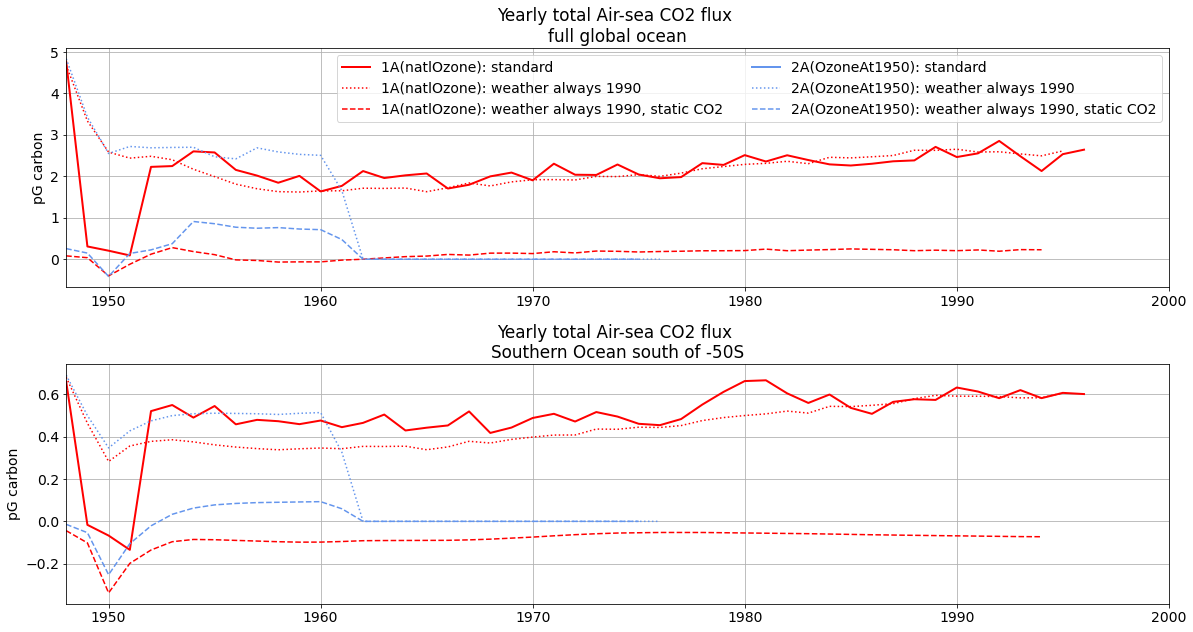

In [155]:
yrs = np.arange(1940,2101,1)
yrstart = 1948; yrend = 2100
mons = np.arange(yrstart,yrend+1,(1/12))

plotlab = ['1A(natlOzone): standard','1A(natlOzone): weather always 1990','1A(natlOzone): weather always 1990, static CO2',\
           '2A(OzoneAt1950): standard','2A(OzoneAt1950): weather always 1990','2A(OzoneAt1950): weather always 1990, static CO2']
plot = [yearflx_1AS1,yearflx_1AW1,yearflx_1AC1,yearflx_2AS1,yearflx_2AW1,yearflx_2AC1]
plot_SO = [yearflx_1AS1_SO,yearflx_1AW1_SO,yearflx_1AC1_SO,yearflx_2AS1_SO,yearflx_2AW1_SO,yearflx_2AC1_SO]
cols = ['red', 'red', 'red', 'cornflowerblue', 'cornflowerblue', 'cornflowerblue']
ls = ['solid','dotted','dashed','solid','dotted','dashed']
lw = [2,1.5,1.5,2,1.5,1.5]
fact = 0.6
fig, axs = plt.subplots(2,1, figsize=(28*fact, 15*fact), \
                        facecolor='w', edgecolor='k')
axs = axs.ravel()
for i in range(0,6):
    axs[0].plot(yrs,plot[i],label = plotlab[i], linestyle = ls[i], color = cols[i], linewidth = lw[i])
    axs[0].legend(ncol = 2)
    axs[1].plot(yrs,plot_SO[i],label = plotlab[i], linestyle = ls[i], color = cols[i], linewidth = lw[i])

tit = ['full global ocean','Southern Ocean south of -50S']
for i in range(0,2):
    axs[i].grid()
    axs[i].set_ylabel('pG carbon')
    axs[i].set_xlim([1948,2000])
    axs[i].set_title(f'Yearly total Air-sea CO2 flux \n{tit[i]}')

plt.tight_layout()

## monthly timeseries of co2

In [156]:
def monthly_Cflx(trun):
    w = nc.Dataset(f'{rdir}/run{trun}_Cflx_pG_month.nc')
    clfx = (w['Cflx'][:])
    monthly_ts = np.zeros([12,161])
    monthly_ts_SO = np.zeros([12,161])
    for i in range(0,12):
        this_month = clfx[:,i,:,:]
        monthly_ts[i,:] = np.nansum(np.nansum(this_month,axis = 1),axis=1) 
        monthly_ts[monthly_ts==0]=np.nan
        monthly_ts_SO[i,:] = np.nansum(np.nansum(this_month[:,0:39,:],axis = 1),axis=1) 
        monthly_ts_SO[monthly_ts_SO==0]=np.nan
    return monthly_ts, monthly_ts_SO

monthflx_1AS1, monthflx_1AS1_SO = monthly_Cflx('1AS1')
monthflx_1AC1, monthflx_1AC1_SO = monthly_Cflx('1AC1')
monthflx_1AW1, monthflx_1AW1_SO = monthly_Cflx('1AW1')
monthflx_2AS1, monthflx_2AS1_SO = monthly_Cflx('2AS1')
monthflx_2AC1, monthflx_2AC1_SO = monthly_Cflx('2AC1')
monthflx_2AW1, monthflx_2AW1_SO = monthly_Cflx('2AW1')

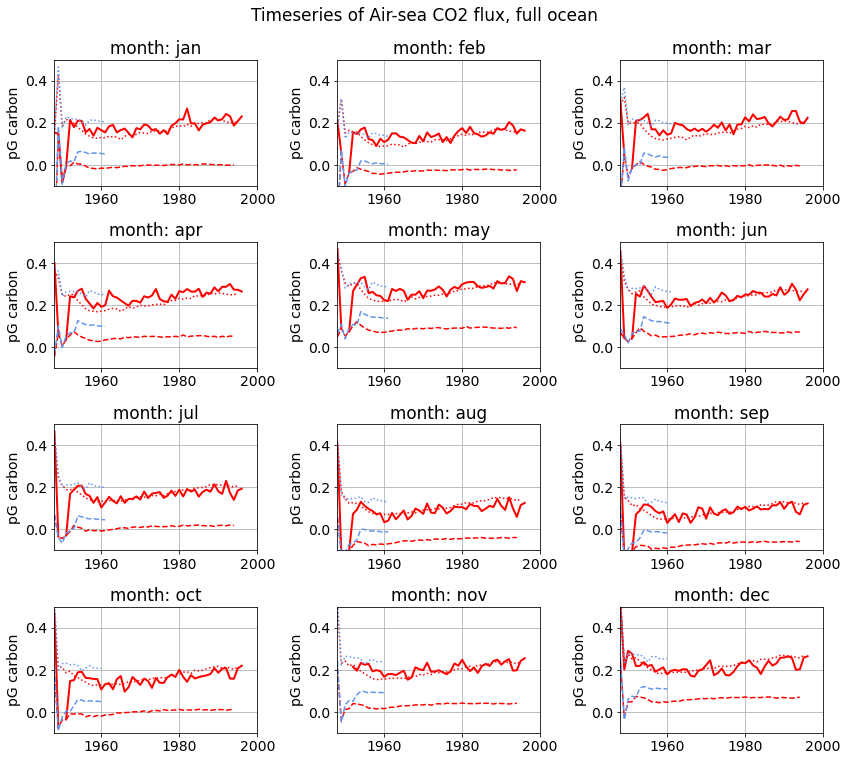

In [157]:
yrs = np.arange(1940,2101,1)
yrstart = 1948; yrend = 2100
mons = np.arange(yrstart,yrend+1,(1/12))

plotlab = ['1A(natlOzone):\n standard','1A(natlOzone):\n weather 1990','1A(natlOzone):\n weather 1990, static CO2',\
           '2A(OzoneAt1950):\n standard','2A(OzoneAt1950):\n weather 1990','2A(OzoneAt1950):\n weather 1990, static CO2']
plot = [monthflx_1AS1,monthflx_1AW1,monthflx_1AC1,monthflx_2AS1,monthflx_2AW1,monthflx_2AC1]
plot_SO = [monthflx_1AS1_SO,monthflx_1AW1_SO,monthflx_1AC1_SO,monthflx_2AS1_SO,monthflx_2AW1_SO,monthflx_2AC1_SO]
cols = ['red', 'red', 'red', 'cornflowerblue', 'cornflowerblue', 'cornflowerblue']
ls = ['solid','dotted','dashed','solid','dotted','dashed']
lw = [2,1.5,1.5,2,1.5,1.5]
fact = 0.6
fig, axs = plt.subplots(4,3, figsize=(20*fact, 18*fact), \
                        facecolor='w', edgecolor='k')

months = ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']
axs = axs.ravel()
for i in range(0,6):
    for s in range(0,12):
        tplt = plot[i]
        axs[s].plot(yrs,tplt[s,:],label = plotlab[i], linestyle = ls[i], color = cols[i], linewidth = lw[i])

for s in range(0,12):
    axs[s].set_title(f'month: {months[s]}')
    axs[s].grid()
    axs[s].set_ylabel('pG carbon')
    axs[s].set_xlim([1948,2000])
    axs[s].set_ylim([-0.1,0.5])
plt.suptitle('Timeseries of Air-sea CO2 flux, full ocean')

plt.tight_layout()

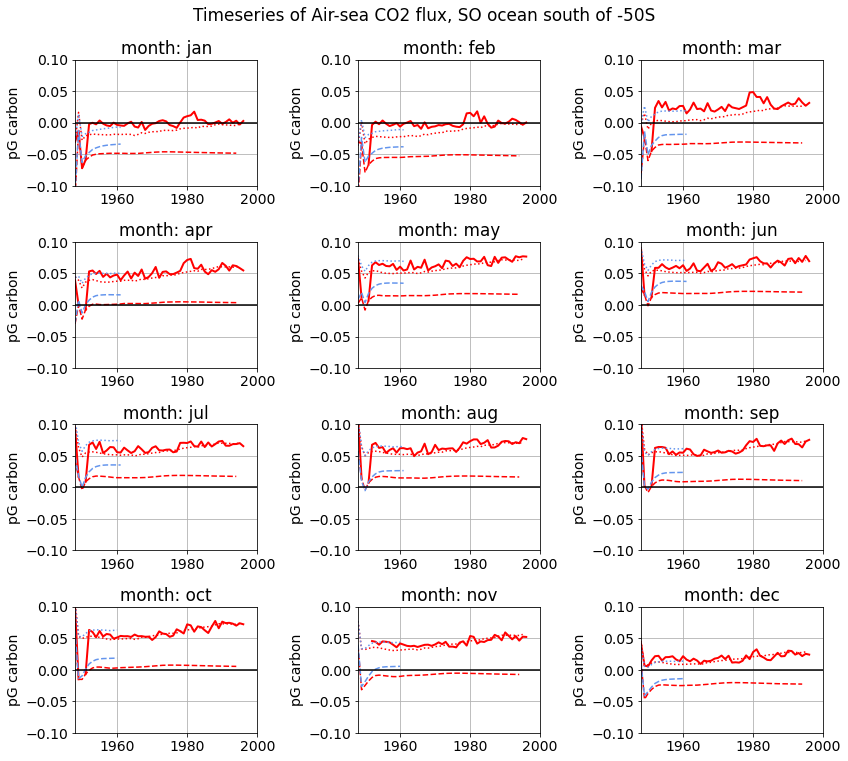

In [160]:
yrs = np.arange(1940,2101,1)
yrstart = 1948; yrend = 2100
mons = np.arange(yrstart,yrend+1,(1/12))

plotlab = ['1A(natlOzone):\n standard','1A(natlOzone):\n weather 1990','1A(natlOzone):\n weather 1990, static CO2',\
           '2A(OzoneAt1950):\n standard','2A(OzoneAt1950):\n weather 1990','2A(OzoneAt1950):\n weather 1990, static CO2']
plot = [monthflx_1AS1,monthflx_1AW1,monthflx_1AC1,monthflx_2AS1,monthflx_2AW1,monthflx_2AC1]
plot_SO = [monthflx_1AS1_SO,monthflx_1AW1_SO,monthflx_1AC1_SO,monthflx_2AS1_SO,monthflx_2AW1_SO,monthflx_2AC1_SO]
cols = ['red', 'red', 'red', 'cornflowerblue', 'cornflowerblue', 'cornflowerblue']
ls = ['solid','dotted','dashed','solid','dotted','dashed']
lw = [2,1.5,1.5,2,1.5,1.5]
fact = 0.6
fig, axs = plt.subplots(4,3, figsize=(20*fact, 18*fact), \
                        facecolor='w', edgecolor='k')

months = ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']
axs = axs.ravel()
for i in range(0,6):
    for s in range(0,12):
        tplt = plot_SO[i]
        axs[s].plot(yrs,tplt[s,:],label = plotlab[i], linestyle = ls[i], color = cols[i], linewidth = lw[i])

for s in range(0,12):
    axs[s].set_title(f'month: {months[s]}')
    axs[s].grid()
    axs[s].set_ylabel('pG carbon')
    axs[s].set_xlim([1948,2000])
    axs[s].set_ylim([-0.1,0.1])
    axs[s].axhline(y=0, color = 'k')
plt.suptitle('Timeseries of Air-sea CO2 flux, SO ocean south of -50S')

plt.tight_layout()

In [161]:
plotlab

['1A(natlOzone):\n standard',
 '1A(natlOzone):\n weather 1990',
 '1A(natlOzone):\n weather 1990, static CO2',
 '2A(OzoneAt1950):\n standard',
 '2A(OzoneAt1950):\n weather 1990',
 '2A(OzoneAt1950):\n weather 1990, static CO2']